# Accident Risk Prediction Model
This notebook builds machine learning models to predict accident risk levels (Low, Medium, High) using Michigan accident data.

## 1. Import Libraries

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

## 2. Load and Explore Data

In [30]:
# Load data
df = pd.read_csv(r"C:\Users\osiri\Downloads\michigan_augmented.csv")

# Display basic info
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
df.head()

Dataset shape: (115315, 13)

Column names:
['Risk_Level', 'City', 'Zipcode', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Sunrise_Sunset', 'Weather_Simple']


,Risk_Level,City,Zipcode,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Sunrise_Sunset,Weather_Simple
0,1,Grand Rapids,49548-1303,37.9,29.2,86.0,29.62,10.0,WSW,15.0,0.01,Night,Cloudy
1,1,Grand Rapids,49503,36.0,26.3,89.0,29.65,10.0,SW,16.1,0.01,Night,Rain
2,1,Detroit,48238,35.1,25.5,89.0,29.69,8.0,WSW,15.0,0.00,Night,Cloudy
3,1,Roseville,48066,35.1,25.9,92.0,29.70,10.0,SW,13.8,0.00,Night,Cloudy
4,1,Coopersville,49404,39.0,32.8,86.0,29.66,10.0,West,9.2,0.02,Night,Rain


In [31]:
# Check data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115315 entries, 0 to 115314
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Risk_Level         115315 non-null  int64  
 1   City               115315 non-null  object 
 2   Zipcode            115315 non-null  object 
 3   Temperature(F)     115315 non-null  float64
 4   Wind_Chill(F)      115315 non-null  float64
 5   Humidity(%)        115315 non-null  float64
 6   Pressure(in)       115315 non-null  float64
 7   Visibility(mi)     115315 non-null  float64
 8   Wind_Direction     106315 non-null  object 
 9   Wind_Speed(mph)    115315 non-null  float64
 10  Precipitation(in)  115315 non-null  float64
 11  Sunrise_Sunset     115315 non-null  object 
 12  Weather_Simple     115315 non-null  object 
dtypes: float64(7), int64(1), object(5)
memory usage: 11.4+ MB


## 3. Verify Target Variable (Risk_Level)

Risk Level Distribution:
Risk_Level
1    96292
0    19023
Name: count, dtype: int64


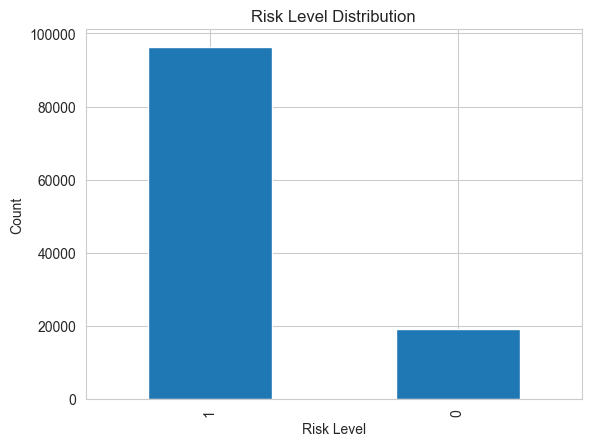

In [32]:
# Check the existing Risk_Level column
print("Risk Level Distribution:")
print(df['Risk_Level'].value_counts())

# Visualize distribution
df['Risk_Level'].value_counts().plot(kind='bar', title='Risk Level Distribution')
plt.ylabel('Count')
plt.xlabel('Risk Level')
plt.show()

## 4. Prepare Features for Modeling

In [33]:
# Drop Zipcode, use Risk_Level as target

X = df.drop(['Risk_Level', 'Zipcode'], axis=1)
y = df['Risk_Level']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns:\n{X.columns.tolist()}")

Features shape: (115315, 11)
Target shape: (115315,)

Feature columns:
['City', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Sunrise_Sunset', 'Weather_Simple']


In [8]:
print(f"Unique zipcodes: {df['City'].nunique()}")

Unique zipcodes: 496


In [34]:
# Encode categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns to encode: {categorical_cols}")

label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print(f"\nEncoded features shape: {X_encoded.shape}")
print(X_encoded.head())

Categorical columns to encode: ['City', 'Wind_Direction', 'Sunrise_Sunset', 'Weather_Simple']

Encoded features shape: (115315, 11)
   City  Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  \
0   186            37.9           29.2         86.0         29.62   
1   186            36.0           26.3         89.0         29.65   
2   119            35.1           25.5         89.0         29.69   
3   397            35.1           25.9         92.0         29.70   
4   107            39.0           32.8         86.0         29.66   

   Visibility(mi)  Wind_Direction  Wind_Speed(mph)  Precipitation(in)  \
0            10.0              21             15.0               0.01   
1            10.0              15             16.1               0.01   
2             8.0              21             15.0               0.00   
3            10.0              15             13.8               0.00   
4            10.0              22              9.2               0.02   

   Sunrise_Sun

In [35]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set distribution:")
print(y_train.value_counts())

Training set size: 92252
Test set size: 23063

Training set distribution:
Risk_Level
1    77034
0    15218
Name: count, dtype: int64


### Apply SMOTE to Balance Training Data

In [36]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Original training set distribution:")
print(y_train.value_counts())
print(f"\nSMOTE balanced training set distribution:")
print(y_train_smote.value_counts())
print(f"\nNew training set size: {X_train_smote.shape[0]}")

Original training set distribution:
Risk_Level
1    77034
0    15218
Name: count, dtype: int64

SMOTE balanced training set distribution:
Risk_Level
1    77034
0    77034
Name: count, dtype: int64

New training set size: 154068


## 5. Build and Evaluate Models

### Model 1: Random Forest Classifier

In [37]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                  class_weight='balanced')
rf_model.fit(X_train_smote, y_train_smote)

# Make predictions
rf_pred = rf_model.predict(X_test)

# Evaluate
print("Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

Random Forest Results:
Accuracy: 0.9898

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3805
           1       0.99      1.00      0.99     19258

    accuracy                           0.99     23063
   macro avg       0.99      0.97      0.98     23063
weighted avg       0.99      0.99      0.99     23063



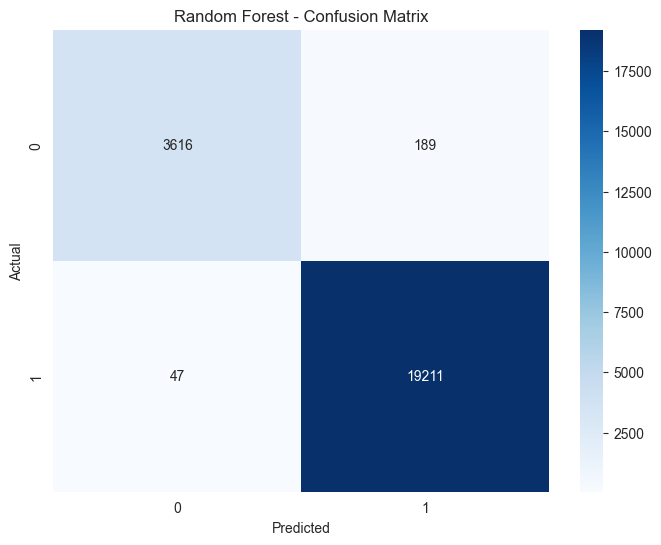

In [38]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()))
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Model 2: Logistic Regression

In [39]:
# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_smote, y_train_smote)

# Make predictions
lr_pred = lr_model.predict(X_test)

# Evaluate
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))

Logistic Regression Results:
Accuracy: 0.7213

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.66      0.44      3805
           1       0.92      0.73      0.81     19258

    accuracy                           0.72     23063
   macro avg       0.62      0.70      0.63     23063
weighted avg       0.82      0.72      0.75     23063



### Model 3: Gradient Boosting Classifier

In [40]:
# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_smote, y_train_smote)

# Make predictions
gb_pred = gb_model.predict(X_test)

# Evaluate
print("Gradient Boosting Results:")
print(f"Accuracy: {accuracy_score(y_test, gb_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, gb_pred))

Gradient Boosting Results:
Accuracy: 0.9894

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      3805
           1       0.99      1.00      0.99     19258

    accuracy                           0.99     23063
   macro avg       0.99      0.97      0.98     23063
weighted avg       0.99      0.99      0.99     23063



## 6. Compare Models

## 7. Feature Importance (Random Forest)

Top 15 Most Important Features:
              Feature  Importance
8   Precipitation(in)    0.502814
5      Visibility(mi)    0.185058
10     Weather_Simple    0.093007
6      Wind_Direction    0.081085
3         Humidity(%)    0.033408
7     Wind_Speed(mph)    0.026265
4        Pressure(in)    0.025733
1      Temperature(F)    0.020570
2       Wind_Chill(F)    0.018788
0                City    0.009072
9      Sunrise_Sunset    0.004202


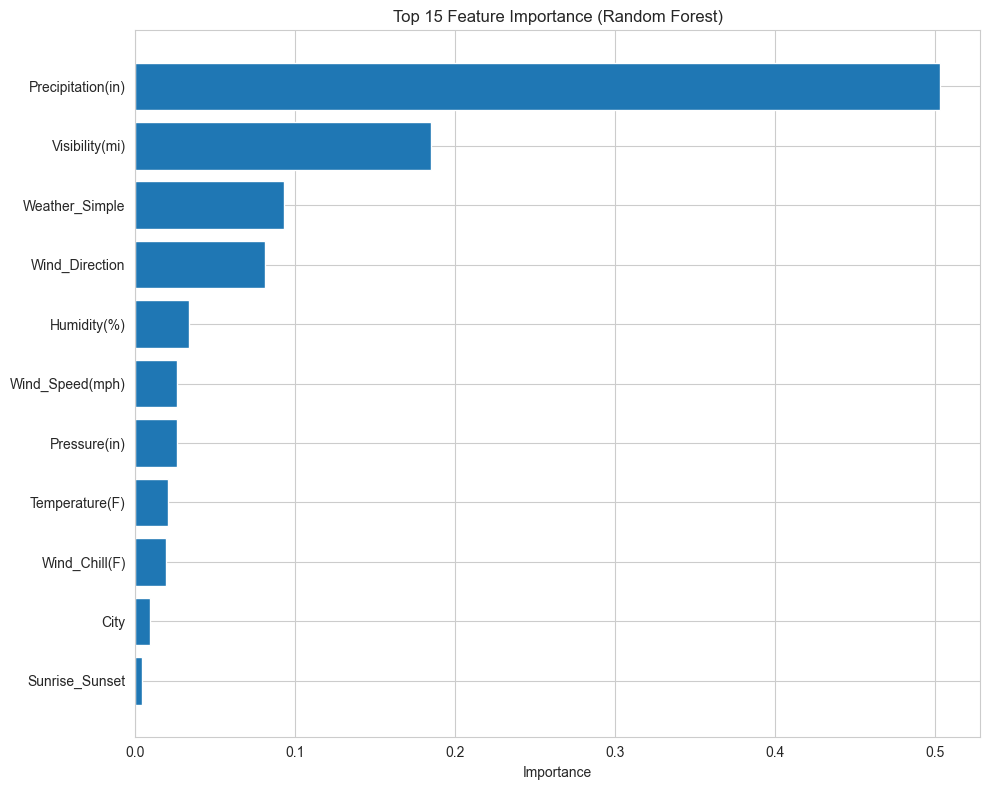

In [41]:
# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Display top 15 features
print("Top 15 Most Important Features:")
print(feature_importance.head(15))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()